


<h1>NOTEBOOK 5 - Modelagem do cenário 02</h1>

Esse notebook apresenta as etapas de pré-processamento, modelagem, validação cruzada e apresentação dos resultados para o cenário 2 do TCC

# **Pré-Processamento dos Dados**

### Instalação da Biblioteca Sktime

In [1]:
pip install sktime[all_extras]

### Importação das Bibliotecas Matplotlib, Seaborn, Numpy e Pandas

In [2]:
from sktime.utils.plotting import plot_series
import matplotlib
import numpy as np
import pandas as pd
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Importação da base de dados mensal

In [4]:
#Importação das séries de vazão e precipitação
df = pd.read_csv('df.csv', parse_dates=['Data'], index_col='Data')
df.index=df.index.to_period("M")
df.head()

,Vazao,Precipitacao
Data,,
1941-01,116.336800,198.68
1941-02,91.653729,121.83
1941-03,100.489190,119.51
1941-04,90.289133,61.22
1941-05,60.699858,19.46


## Criação do dataframe com 7 variáveis dependentes

In [5]:
#Copiando o dataframe e gerando 6 variáveis defasadas
df2 = df.copy()
df2['Q1'] = df2['Vazao'].shift(1)
df2['Q2'] = df2['Vazao'].shift(2)
df2['Q3'] = df2['Vazao'].shift(3)
df2['P1']=df2['Precipitacao'].shift(1)
df2['P2']=df2['Precipitacao'].shift(2)
df2['P3']=df2['Precipitacao'].shift(3)
df2.head()

,Vazao,Precipitacao,Q1,Q2,Q3,P1,P2,P3
Data,,,,,,,,
1941-01,116.336800,198.68,NaN,NaN,NaN,NaN,NaN,NaN
1941-02,91.653729,121.83,116.336800,NaN,NaN,198.68,NaN,NaN
1941-03,100.489190,119.51,91.653729,116.336800,NaN,121.83,198.68,NaN
1941-04,90.289133,61.22,100.489190,91.653729,116.336800,119.51,121.83,198.68
1941-05,60.699858,19.46,90.289133,100.489190,91.653729,61.22,119.51,121.83


In [6]:
#Retirando os dados nulos
df2.dropna(inplace=True)
df2.head()

,Vazao,Precipitacao,Q1,Q2,Q3,P1,P2,P3
Data,,,,,,,,
1941-04,90.289133,61.22,100.489190,91.653729,116.336800,119.51,121.83,198.68
1941-05,60.699858,19.46,90.289133,100.489190,91.653729,61.22,119.51,121.83
1941-06,56.145653,15.15,60.699858,90.289133,100.489190,19.46,61.22,119.51
1941-07,54.765916,53.19,56.145653,60.699858,90.289133,15.15,19.46,61.22
1941-08,45.229942,1.47,54.765916,56.145653,60.699858,53.19,15.15,19.46


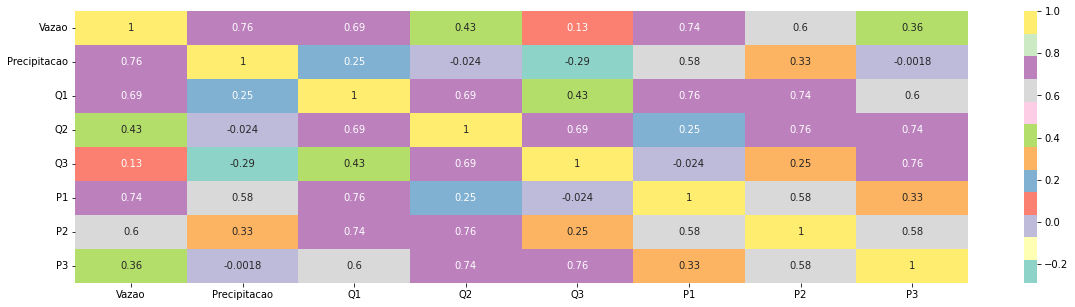

In [7]:
#Mapa de correlação entre as variáveis
plt.figure(figsize=(20,5))
correlacao=df2.corr()
sns.heatmap(correlacao, annot = True, cmap = "Set3");

## Transformação das Curvas

In [8]:
#Funções para reverter as transformações
def power_2(x):
  return(np.power(x,2))

def base_10(x):
  return(np.power(10,x))


In [9]:
#Transformações: log(vazão) e raiz(precipitação)
from sklearn.preprocessing import FunctionTransformer

transformer_log = FunctionTransformer(np.log10, inverse_func = base_10 , validate = True,check_inverse=False)
transformer_sqrt = FunctionTransformer(np.sqrt, inverse_func= power_2, validate = True,check_inverse=False)

df2[['Vazao']] = transformer_log.fit_transform(df2[['Vazao']])
df2[['Q1']] = transformer_log.fit_transform(df2[['Q1']])
df2[['Q2']] = transformer_log.fit_transform(df2[['Q2']])
df2[['Q3']] = transformer_log.fit_transform(df2[['Q3']])
df2[['Precipitacao']] = transformer_sqrt.fit_transform(df2[['Precipitacao']])
df2[['P1']] = transformer_sqrt.fit_transform(df2[['P1']])
df2[['P2']] = transformer_sqrt.fit_transform(df2[['P2']])
df2[['P3']] = transformer_sqrt.fit_transform(df2[['P3']])
df2.head()

,Vazao,Precipitacao,Q1,Q2,Q3,P1,P2,P3
Data,,,,,,,,
1941-04,1.955635,7.824321,2.002119,1.962150,2.065717,10.932063,11.037663,14.095389
1941-05,1.783188,4.411349,1.955635,2.002119,1.962150,7.824321,10.932063,11.037663
1941-06,1.749316,3.892300,1.783188,1.955635,2.002119,4.411349,7.824321,10.932063
1941-07,1.738510,7.293147,1.749316,1.783188,1.955635,3.892300,4.411349,7.824321
1941-08,1.655426,1.212436,1.738510,1.749316,1.783188,7.293147,3.892300,4.411349


## Normalização dos Dados

In [10]:
#Colocando na escala de 0.1 a 0.9
from sklearn.preprocessing import MinMaxScaler

scaler_1 = MinMaxScaler(feature_range=(0.1,0.9))
scaler_2 = MinMaxScaler(feature_range=(0.1,0.9))

df2[['Vazao']] = scaler_1.fit_transform(df2[['Vazao']])
df2[['Q1']] = scaler_1.fit_transform(df2[['Q1']])
df2[['Q2']] = scaler_1.fit_transform(df2[['Q2']])
df2[['Q3']] = scaler_1.fit_transform(df2[['Q3']])
df2[['Precipitacao']] = scaler_2.fit_transform(df2[['Precipitacao']])
df2[['P1']] = scaler_2.fit_transform(df2[['P1']])
df2[['P2']] = scaler_2.fit_transform(df2[['P2']])
df2[['P3']] = scaler_2.fit_transform(df2[['P3']])

df2.head()



,Vazao,Precipitacao,Q1,Q2,Q3,P1,P2,P3
Data,,,,,,,,
1941-04,0.571008,0.351784,0.598114,0.574807,0.625681,0.451790,0.455188,0.553585
1941-05,0.470447,0.241956,0.571008,0.598114,0.563116,0.351784,0.451790,0.455188
1941-06,0.450696,0.225253,0.470447,0.571008,0.587262,0.241956,0.351784,0.451790
1941-07,0.444394,0.334691,0.450696,0.470447,0.559181,0.225253,0.241956,0.351784
1941-08,0.395945,0.139016,0.444394,0.450696,0.455005,0.334691,0.225253,0.241956


**Divisão da Base de Dados**

In [11]:
#Divisão da base em treino e teste
y=df2['Vazao']
X=df2.drop('Vazao',axis=1)

from sktime.forecasting.model_selection import temporal_train_test_split

y_train,y_test,x_train,x_test= temporal_train_test_split(y,X,test_size=0.25)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

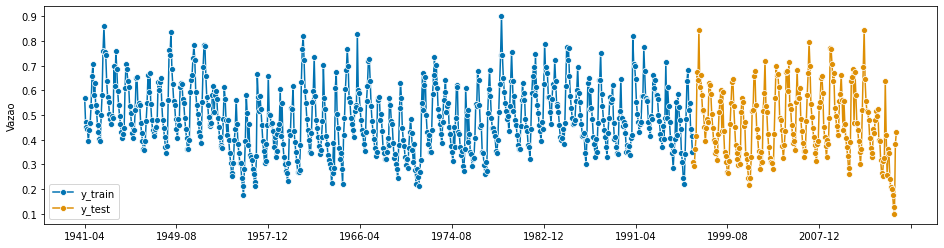

In [12]:
plot_series(y_train,y_test, labels=["y_train", "y_test"])

**Definição dos Horizontes de plotagem e previsão**

In [13]:
#Definição do período de plotagem dos dados
y_train_menor=y_train[600:]

#Definição do horizonte de previsão
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(y_test.index, is_relative=False)

# **Aplicação dos Modelos estatísticos**

## Modelo AutoARIMA exógeno

In [14]:
#Ajuste do AutoARIMA exógeno
from sktime.forecasting.arima import AutoARIMA

forecaster_autoarima_exo2 = AutoARIMA(start_p=1, d=None, start_q=1, max_p=2, max_q=2, start_P=1, D=None, start_Q=1, max_P=2, max_Q=2, 
                                        sp=12, seasonal=True, stationary=True, suppress_warnings=True, information_criterion='aic', scoring='mse')
forecaster_autoarima_exo2.fit(y_train,X=x_train)

print(forecaster_autoarima_exo2.summary())

                                   SARIMAX Results                                   
Dep. Variable:                             y   No. Observations:                  663
Model:             SARIMAX(2, 0, [1, 2], 12)   Log Likelihood                1176.671
Date:                       Sat, 16 Apr 2022   AIC                          -2327.342
Time:                               01:13:22   BIC                          -2268.884
Sample:                           04-30-1941   HQIC                         -2304.688
                                - 06-30-1996                                         
Covariance Type:                         opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -0.0128      0.008     -1.610      0.107      -0.028       0.003
Precipitacao     0.4904      0.014     35.342      0.000       0.463 

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

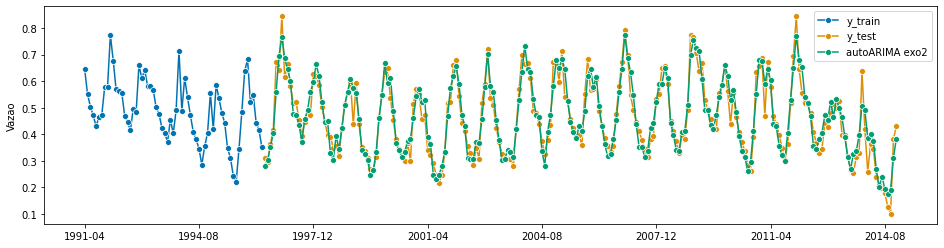

In [15]:
#Previsões do AutoARIMA exógeno

y_pred_autoarima_exo2 = forecaster_autoarima_exo2.predict(fh,X=x_test)

plot_series(y_train_menor, y_test, y_pred_autoarima_exo2, labels=["y_train", "y_test", "autoARIMA exo2"])

## Modelo SARIMAX

In [16]:
#Ajuste do SARIMAX
from sktime.forecasting.arima import ARIMA
forecaster_arima_exo2 = ARIMA(
    order=(2,0,1), seasonal_order=(2,0,2, 12),
    maxiter=100,
    suppress_warnings=True,
    time_varying_regression=True
)

forecaster_arima_exo2.fit(y_train,X=x_train)
print(forecaster_arima_exo2.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  663
Model:             SARIMAX(2, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                1185.972
Date:                                 Sat, 16 Apr 2022   AIC                          -2339.945
Time:                                         01:13:56   BIC                          -2267.996
Sample:                                     04-30-1941   HQIC                         -2312.063
                                          - 06-30-1996                                         
Covariance Type:                                   opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -0.0050      0.005     -0.980      0.327      -0.015  

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

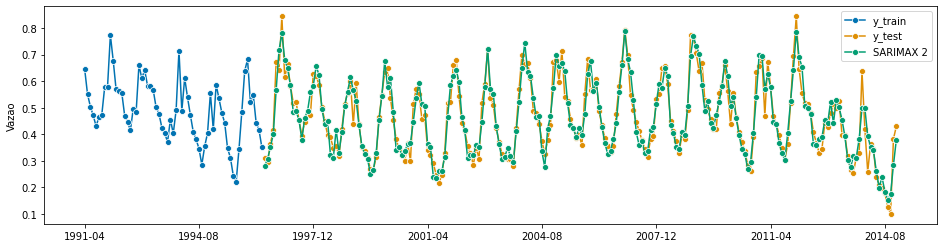

In [17]:
#Previsões do SARIMAX
y_pred_arima_exo2 = forecaster_arima_exo2.predict(fh,X=x_test)
plot_series(y_train_menor, y_test, y_pred_arima_exo2, labels=["y_train", "y_test", "SARIMAX 2"])

## Modelo Prophet

In [18]:
#Ajuste do Prophet
from sktime.forecasting.fbprophet import Prophet

z = y.copy()
z = z.to_timestamp(freq="M")
z_train, z_test = temporal_train_test_split(z, test_size=222)
ds=X
ds = ds.to_timestamp(freq="M")
ds_train, ds_test = temporal_train_test_split(ds, test_size=222)

forecaster_prophet2 = Prophet(
    seasonality_mode="additive",
    n_changepoints=int(len(y_train) / 12),
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)

forecaster_prophet2.fit(z_train,X=ds_train)

Prophet(daily_seasonality=False, n_changepoints=55, weekly_seasonality=False,
        yearly_seasonality=True)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

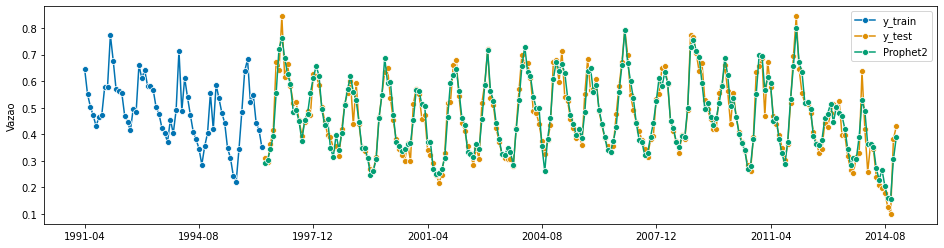

In [19]:
#Previsões do Prophet
y_pred_prophet2= forecaster_prophet2.predict(fh.to_relative(cutoff=y_train.index[-1]),ds_test )
y_pred_prophet2.index = y_test.index

plot_series(y_train_menor, y_test, y_pred_prophet2, labels=["y_train", "y_test", "Prophet2"])

## Comparação entre os modelos sem validação cruzada

In [20]:
print('MAPE')
print('AutoARIMA exo 2   ',mean_absolute_percentage_error(y_test, y_pred_autoarima_exo2,symmetric=False).round(5))
print('SARIMAx 2    ',mean_absolute_percentage_error(y_test, y_pred_arima_exo2,symmetric=False).round(5))
print('Prophet 2 :',mean_absolute_percentage_error(y_test, y_pred_prophet2,symmetric=False).round(5))
print('MSE')
print('AutoARIMA 2 :',mean_squared_error(y_test, y_pred_autoarima_exo2).round(5))
print('SARIMAx 2   ',mean_squared_error(y_test, y_pred_arima_exo2,symmetric=False).round(5))
print('Prophet 2 :',mean_squared_error(y_test, y_pred_prophet2).round(5))

MAPE
AutoARIMA exo 2    0.08231
SARIMAx 2     0.07628
Prophet 2 : 0.06963
MSE
AutoARIMA 2 : 0.00191
SARIMAx 2    0.00189
Prophet 2 : 0.00154


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

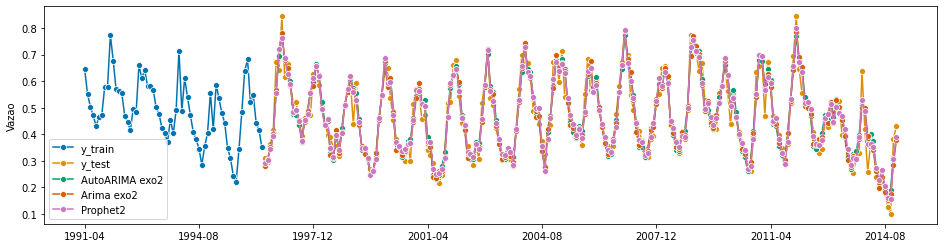

In [21]:
#Plotagem das previsões
plot_series(y_train_menor, y_test,
            y_pred_autoarima_exo2,
            y_pred_arima_exo2,
            y_pred_prophet2,
            labels=["y_train", "y_test", 
                    'AutoARIMA exo2',
                    'Arima exo2',
                    'Prophet2'])

## Validação Cruzada dos modelos

In [22]:
#Importação das Bibliotecas de CV e definição das janelas
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.performance_metrics.forecasting import MeanSquaredError


cv = SlidingWindowSplitter(
    fh=60, window_length=300, step_length = 36
)


In [23]:
#CV do modelo AutoARIMA exógeno
df_autoarima_exo = evaluate(forecaster=forecaster_autoarima_exo2, y=y, X=X, cv=cv, strategy="refit", return_data=True)

df_autoarima_exo_mse = evaluate(forecaster=forecaster_autoarima_exo2, y=y, X=X, cv=cv, strategy="refit", return_data=True,
                    scoring=MeanSquaredError())

In [24]:
#CV do modelo SARIMAX
df_arima_exo = evaluate(forecaster=forecaster_arima_exo2, y=y, X=X, cv=cv, strategy="refit", return_data=True)

df_arima_exo_mse = evaluate(forecaster=forecaster_arima_exo2, y=y, X=X, cv=cv, strategy="refit", return_data=True,
                    scoring=MeanSquaredError())

In [25]:
#CV do modelo Prophet
dsnovo=df2.drop('Vazao',axis=1)
dsnovo=dsnovo.to_timestamp(freq='M')
df_prophet = evaluate(forecaster=forecaster_prophet2, y=z,X=dsnovo, cv=cv, strategy="refit", return_data=True)

df_prophet_mse = evaluate(forecaster=forecaster_prophet2, y=z,X=dsnovo, cv=cv, strategy="refit", return_data=True,
                    scoring=MeanSquaredError())

In [26]:
#Métricas das CVs dos modelos estatísticos
print('Média MAPE dos modelos da Validação Cruzada:')
print('AutoARIMA exo : ',round(df_autoarima_exo['test_MeanAbsolutePercentageError'].mean(),5))
print('SARIMAx :       ',round(df_arima_exo['test_MeanAbsolutePercentageError'].mean(),5))
print('Prophet :       ',round(df_prophet['test_MeanAbsolutePercentageError'].mean(),5))
print('Média MSE dos modelos da Validação Cruzada:')
print('AutoARIMA exo :',round(df_autoarima_exo_mse['test_MeanSquaredError'].mean(),5))
print('SARIMAx :      ',round(df_arima_exo_mse['test_MeanSquaredError'].mean(),5))
print('Prophet :      ',round(df_prophet_mse['test_MeanSquaredError'].mean(),5))

Média MAPE dos modelos da Validação Cruzada:
AutoARIMA exo :  0.06698
SARIMAx :        0.07017
Prophet :        0.06181
Média MSE dos modelos da Validação Cruzada:
AutoARIMA exo : 0.00201
SARIMAx :       0.00196
Prophet :       0.00147


# **Construção e Aplicação das Redes Neurais**

##Pré-Processamento

In [27]:
#Importação de bibliotecas
import tensorflow as tf
from tensorflow import keras
from numpy.random import seed
from tensorflow.random import set_seed
from keras.layers import Dropout


## Rede MLP

In [28]:
#Construção da rede
modelDense2 = keras.models.Sequential()
modelDense2.add(keras.layers.Dense(16, activation='tanh', input_dim=7))
modelDense2.add(keras.layers.Dense(4, activation='tanh'))
modelDense2.add(Dropout(0.2))
modelDense2.add(keras.layers.Dense(1, activation='linear'))
modelDense2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                128       
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


In [29]:
#Definição de estado
seed(2)
set_seed(2)

#Definição de parâmetros de ajuste
batch_size = 64
epochs = 100
learning_rate = 0.01

#Ajuste da rede
modelDense2.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=learning_rate),metrics=['mse'])
hist_dense2 = modelDense2.fit(x=x_train,y=y_train, epochs=epochs,batch_size=batch_size,verbose=0, shuffle=False)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

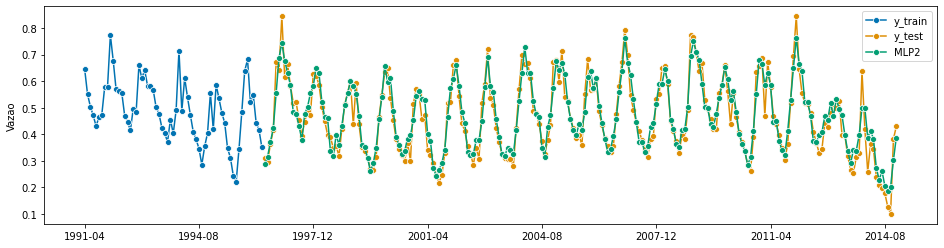

In [30]:
#Previsão e métricas da rede
pred_dense2 = modelDense2.predict(x_test).reshape(-1)
y_pred_dense2=pd.Series(pred_dense2, index=y_test.index)

plot_series(y_train_menor, y_test,
            y_pred_dense2,
            labels=["y_train", "y_test", 
                    'MLP2'])

## Rede Recorrente

In [31]:
#Criação da função time_step
def create_dataset_time_step(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


In [32]:
#Definição do time step e bases de treino e teste
time_steps = 3

X_train_ts, y_train_ts = create_dataset_time_step(x_train,y_train, time_steps)
X_test_ts, y_test_ts = create_dataset_time_step(x_test,y_test, time_steps)

print(X_train_ts.shape, y_train_ts.shape)
print(X_test_ts.shape, y_test_ts.shape)

(660, 3, 7) (660,)
(219, 3, 7) (219,)


In [33]:
#Construção da rede neural recorrente
seed(2)
set_seed(2)
modelSimpleRNN2 = keras.models.Sequential()
modelSimpleRNN2.add(keras.layers.SimpleRNN(16, activation='tanh', return_sequences=True, input_shape=(X_train_ts.shape[1],X_train_ts.shape[2])))
modelSimpleRNN2.add(keras.layers.SimpleRNN(4, activation='tanh', return_sequences=False))
modelSimpleRNN2.add(Dropout(0.2))
modelSimpleRNN2.add(keras.layers.Dense(1, activation='linear'))
modelSimpleRNN2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3, 16)             384       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 4)                 84        
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 473
Trainable params: 473
Non-trainable params: 0
_________________________________________________________________


In [34]:
#Definição de estado
seed(2)
set_seed(2)

#Definição de parâmetros de ajuste
batch_size = 64
epochs = 100
learning_rate = 0.01

#Ajuste da RNR
modelSimpleRNN2.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=learning_rate,decay=0.001),metrics=['mse'])
hist_SimpleRNN2 = modelSimpleRNN2.fit(x=X_train_ts, y=y_train_ts, epochs=epochs,batch_size=batch_size,verbose=0, shuffle=False)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

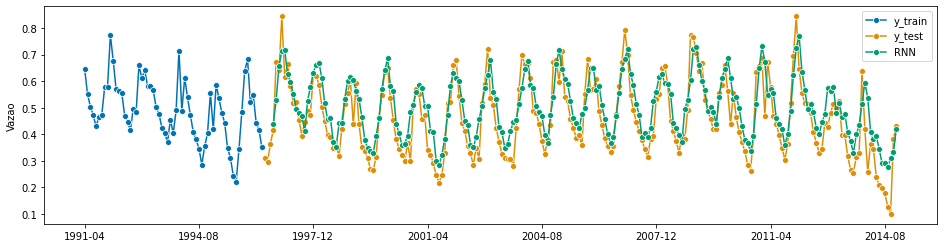

In [35]:
#Previsão e métricas da rede
pred_SimpleRNN2 = modelSimpleRNN2.predict(X_test_ts)
y_pred_SimpleRNN2=pd.Series(pred_SimpleRNN2.reshape(-1), index=y_test.index[time_steps::])

plot_series(y_train_menor, y_test,
            y_pred_SimpleRNN2,
            labels=["y_train", "y_test",
                    'RNN'
                    ])

**Comparando as duas redes**

In [36]:
#Métricas
print('MAPE')
print('MLP   ',mean_absolute_percentage_error(y_test, pred_dense2).round(5))
print('RNN   ',mean_absolute_percentage_error(y_test_ts, pred_SimpleRNN2).round(5))

print('MSE')
print('MLP :',mean_squared_error(y_test, pred_dense2).round(5))
print('RNN   ',mean_squared_error(y_test_ts, pred_SimpleRNN2).round(5))

MAPE
MLP    0.08034
RNN    0.14985
MSE
MLP : 0.00201
RNN    0.00641


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

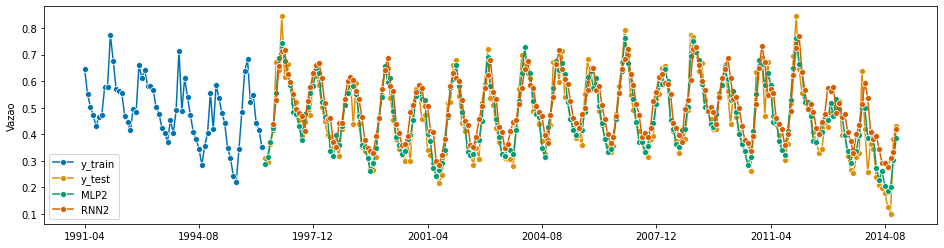

In [37]:
#Gráficos
plot_series(y_train_menor, y_test,
            y_pred_dense2,
            y_pred_SimpleRNN2,
            labels=["y_train", "y_test", 
                    'MLP2',
                    'RNN2'])

**Gráfico dos melhores modelos**

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

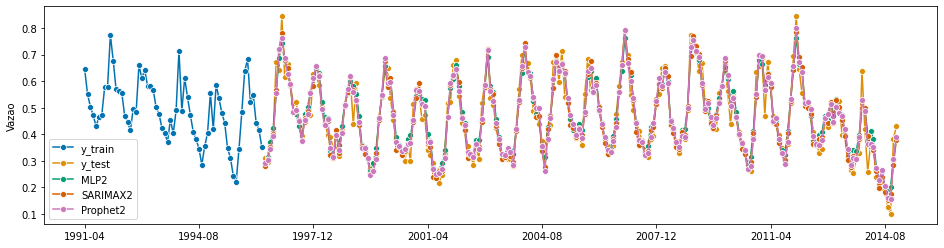

In [38]:
plot_series(y_train_menor, y_test,
            y_pred_dense2,
            y_pred_arima_exo2,
            y_pred_prophet2,
            labels=["y_train", "y_test", 
                    'MLP2',
                    'SARIMAX2',
                    'Prophet2'])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Vazao'>)

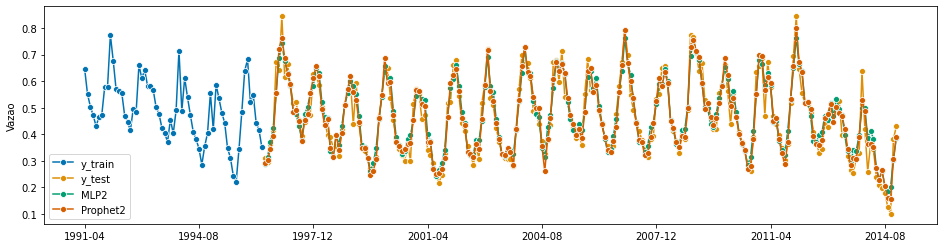

In [39]:
plot_series(y_train_menor, y_test,
            y_pred_dense2,
            y_pred_prophet2,
            labels=["y_train", "y_test",
                    'MLP2',
                    'Prophet2'])

## Validação Cruzada dos modelos

In [40]:
#Definindo X e y
X_cv = df2.drop('Vazao',axis=1).values
y_cv = df2['Vazao'].values

#Selecionando as linhas de treino e teste
dense2_cv_y = []
dense2_cv_pred = []

fold = 0
for train, test in cv.split(y):
    fold+=1
    gp_test = np.arange(test-59,test+1)

    x_train_cv = X_cv[train]
    y_train_cv = y_cv[train]
    x_test_cv = X_cv[gp_test]
    y_test_cv = y_cv[gp_test]

#Contruindo a rede
    seed(2)
    set_seed(2)
    modelDense2_cv = keras.models.Sequential()
    modelDense2_cv.add(keras.layers.Dense(16, activation='tanh', input_dim=7))
    modelDense2_cv.add(keras.layers.Dense(4, activation='tanh'))
    modelDense2_cv.add(Dropout(0.2))
    modelDense2_cv.add(keras.layers.Dense(1, activation='linear'))
    modelDense2_cv.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=learning_rate),metrics=['mse'])
 
 #CV do modelo MLP   
    modelDense2_cv.fit(x_train_cv,y_train_cv,validation_data=(x_test_cv,y_test_cv),verbose=0,
              epochs=epochs,
              batch_size=batch_size, shuffle=False)
    
    pred_dense2_cv = modelDense2_cv.predict(x_test_cv)
    
    dense2_cv_y.append(y_test_cv)
    dense2_cv_pred.append(pred_dense2_cv)  
        
    mse2_dense_fold = mean_squared_error(pred_dense2_cv,y_test_cv)
    mape2_dense_fold = mean_absolute_percentage_error(pred_dense2_cv,y_test_cv)

In [41]:
#Definindo X, y e o passo temporal
X2_cv = df2.drop('Vazao',axis=1)
y2_cv = df2['Vazao']


SimpleRNN2_cv_y = []
SimpleRNN2_cv_pred = []
time_steps=3

#Selecionando as linhas de treino e teste
fold = 0
for train, test in cv.split(y):
    fold+=1
    gp_test = np.arange(test-59,test+1)

    x_train_cv = X2_cv.iloc[train]
    y_train_cv = y2_cv[train]
    x_test_cv = X2_cv.iloc[gp_test]
    y_test_cv = y2_cv[gp_test]

    X_train_ts_cv, y_train_ts_cv = create_dataset_time_step(x_train_cv,y_train_cv, time_steps)
    X_test_ts_cv, y_test_ts_cv = create_dataset_time_step(x_test_cv,y_test_cv, time_steps)

    X_train_ts_cv=X_train_ts_cv.reshape(300-time_steps,time_steps,7)
    X_test_ts_cv=X_test_ts_cv.reshape(60-time_steps,time_steps,7)

#Contruindo a rede
    modelSimpleRNN2_cv = keras.models.Sequential()
    modelSimpleRNN2_cv.add(keras.layers.SimpleRNN(16, activation='tanh', return_sequences=True, input_shape=(X_train_ts.shape[1],X_train_ts.shape[2])))
    modelSimpleRNN2_cv.add(keras.layers.SimpleRNN(4, activation='tanh', return_sequences=False))
    modelSimpleRNN2_cv.add(Dropout(0.2))
    modelSimpleRNN2_cv.add(keras.layers.Dense(1, activation='linear'))
    modelSimpleRNN2_cv.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=learning_rate),metrics=['mse'])
    modelSimpleRNN2_cv.fit(x=X_train_ts_cv, y=y_train_ts_cv, epochs=epochs,batch_size=batch_size,verbose=0, shuffle=False)

    pred_SimpleRNN2_cv = modelSimpleRNN2_cv.predict(X_test_ts_cv)

    SimpleRNN2_cv_y.append(y_test_ts_cv)
    SimpleRNN2_cv_pred.append(pred_SimpleRNN2_cv) 

    mse_SimpleRNN2_fold = mean_squared_error(pred_SimpleRNN2_cv,y_test_ts_cv)
    mape_SimpleRNN2_fold = mean_absolute_percentage_error(pred_SimpleRNN2_cv,y_test_ts_cv)

In [42]:
#Concatenando os arrays
dense2_cv_y_1 = np.concatenate(dense2_cv_y)
dense2_cv_pred_1 = np.concatenate(dense2_cv_pred)

SimpleRNN2_cv_y_1 = np.concatenate(SimpleRNN2_cv_y)
SimpleRNN2_cv_pred_1 = np.concatenate(SimpleRNN2_cv_pred)

In [43]:
#Cálculo das métricas da CV das redes
mape_dense2_cv = mean_absolute_percentage_error(dense2_cv_pred_1,dense2_cv_y_1)
mse_dense2_cv = mean_squared_error(dense2_cv_pred_1,dense2_cv_y_1)
print(f" MAPE - Validação Cruzada - MLP : {mape_dense2_cv}") 
print(f" MSE - Validação Cruzada - MLP : {mse_dense2_cv}") 


print("") 
mape_SimpleRNN2_cv = mean_absolute_percentage_error(SimpleRNN2_cv_pred_1,SimpleRNN2_cv_y_1)
mse_SimpleRNN2_cv = mean_squared_error(SimpleRNN2_cv_pred_1,SimpleRNN2_cv_y_1)
print(f" MAPE - Validação Cruzada - SimpleRNN :  {mape_SimpleRNN2_cv}") 
print(f" MSE - Validação Cruzada - SimpleRNN :  {mse_SimpleRNN2_cv}") 

 MAPE - Validação Cruzada - MLP : 0.07413458104860819
 MSE - Validação Cruzada - MLP : 0.002040060696526477

 MAPE - Validação Cruzada - SimpleRNN :  0.10711047456901336
 MSE - Validação Cruzada - SimpleRNN :  0.004874389209711349


# **Comparação dos Modelos**


**Sem Validação Cruzada**

In [48]:
print('MAPE')
print('AutoARIMA exo 2 :',mean_absolute_percentage_error(y_test, y_pred_autoarima_exo2,symmetric=False).round(5))
print('SARIMAx 2 :      ',mean_absolute_percentage_error(y_test, y_pred_arima_exo2,symmetric=False).round(5))
print('Prophet 2 :      ',mean_absolute_percentage_error(y_test, y_pred_prophet2,symmetric=False).round(5))
print('MLP :            ',mean_absolute_percentage_error(y_test, pred_dense2).round(5))
print('RNN :            ',mean_absolute_percentage_error(y_test_ts, pred_SimpleRNN2).round(5))


print('MSE')
print('AutoARIMA 2 :    ',mean_squared_error(y_test, y_pred_autoarima_exo2).round(5))
print('SARIMAx 2 :      ',mean_squared_error(y_test, y_pred_arima_exo2,symmetric=False).round(5))
print('Prophet 2 :      ',mean_squared_error(y_test, y_pred_prophet2).round(5))
print('MLP :            ',mean_squared_error(y_test, pred_dense2).round(5))
print('RNN :            ',mean_squared_error(y_test_ts, pred_SimpleRNN2).round(5))

MAPE
AutoARIMA exo 2 : 0.08231
SARIMAx 2 :       0.07628
Prophet 2 :       0.06963
MLP :             0.08034
RNN :             0.14985
MSE
AutoARIMA 2 :     0.00191
SARIMAx 2 :       0.00189
Prophet 2 :       0.00154
MLP :             0.00201
RNN :             0.00641


**Com Validação Cruzada**

In [49]:
print('Média sMAPE dos modelos da Validação Cruzada:')
print('AutoARIMA exo : ',round(df_autoarima_exo['test_MeanAbsolutePercentageError'].mean(),5))
print('SARIMAx :       ',round(df_arima_exo['test_MeanAbsolutePercentageError'].mean(),5))
print('Prophet :       ',round(df_prophet['test_MeanAbsolutePercentageError'].mean(),5))
print('MLP :         ',round(mape_dense2_cv,5))
print('RNN :           ',round(mape_SimpleRNN2_cv,5))
print('Média MSE dos modelos da Validação Cruzada:')
print('AutoARIMA exo :',round(df_autoarima_exo_mse['test_MeanSquaredError'].mean(),5))
print('SARIMAx :      ',round(df_arima_exo_mse['test_MeanSquaredError'].mean(),5))
print('Prophet :      ',round(df_prophet_mse['test_MeanSquaredError'].mean(),5))
print('MLP :        ',round(mse_dense2_cv,5))
print('RNN :          ',round(mse_SimpleRNN2_cv,5))

Média sMAPE dos modelos da Validação Cruzada:
AutoARIMA exo :  0.06698
SARIMAx :        0.07017
Prophet :        0.06181
MLP :          0.07413
RNN :            0.10711
Média MSE dos modelos da Validação Cruzada:
AutoARIMA exo : 0.00201
SARIMAx :       0.00196
Prophet :       0.00147
MLP :         0.00204
RNN :           0.00487


# **Gráficos em Escala Real**

In [50]:
def inverter_escala(y,y_base,time_step=0):
  y_inv = scaler_1.inverse_transform(y.values.reshape(-1, 1))
  y_inv = transformer_log.inverse_transform(y_inv)
  y_inv = pd.Series(y_inv.reshape(-1), index=y_base.index[time_step::]) 
  return(y_inv)

In [51]:
y_train_menor_inv = inverter_escala(y_train_menor,y_train_menor)
y_test_inv = inverter_escala(y_test,y_test)
y_pred_SimpleRNN2_inv = inverter_escala(y_pred_SimpleRNN2,y_test,time_steps)
y_pred_dense2_inv = inverter_escala(y_pred_dense2,y_test)
y_pred_arima_exo2_inv  = inverter_escala(y_pred_arima_exo2,y_test)
y_pred_prophet2_inv  = inverter_escala(y_pred_prophet2,y_test)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

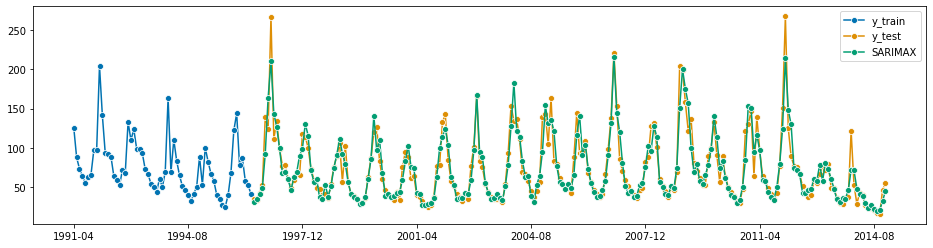

In [52]:
plot_series(y_train_menor_inv,y_test_inv, y_pred_arima_exo2_inv,
            labels=["y_train", "y_test",
                    "SARIMAX"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

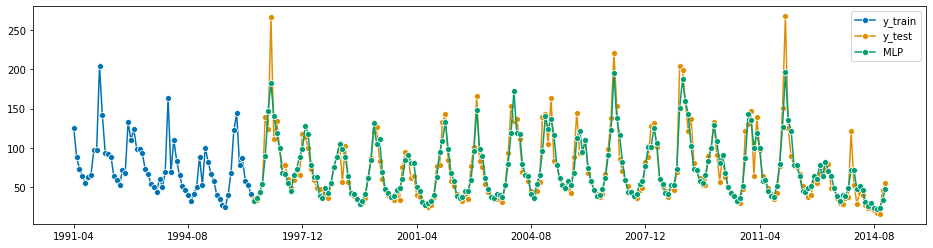

In [53]:
plot_series(y_train_menor_inv,y_test_inv, y_pred_dense2_inv,
            labels=["y_train", "y_test",
                    "MLP"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

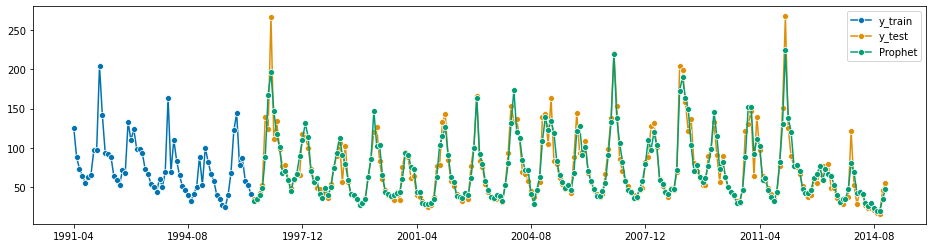

In [54]:
plot_series(y_train_menor_inv,y_test_inv, y_pred_prophet2_inv,
            labels=["y_train", "y_test",
                    "Prophet"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

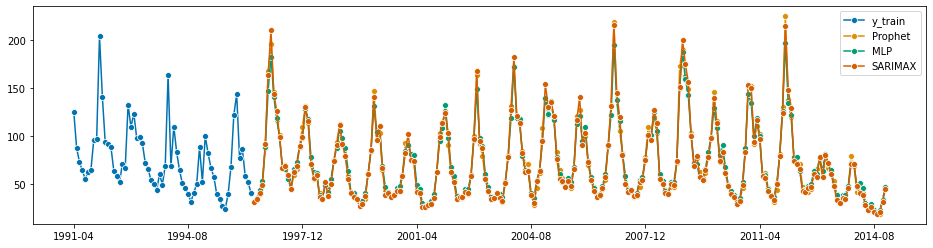

In [55]:
plot_series(y_train_menor_inv,y_pred_prophet2_inv,y_pred_dense2_inv,
            y_pred_arima_exo2_inv,
             labels=["y_train", "Prophet", 
                    "MLP","SARIMAX"])